## Predicting house prices:

In this project, I'm going to predict house prices using a housing dataset from Ames, Iowa. I'm going use Linear Regression algorithm to build the prediction model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

## Data exploration:

In [2]:
pd.options.display.max_columns = 150
df = pd.read_csv('AmesHousing.tsv', delimiter='\t')
df.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Null Values:

In this section, I will be dealing with null values:

* Drop any column with more than 5% null values 
* Out of the remaining null values (columns with 5% or less null values):
   - Drop any text column containing 1 or more null values
   - Fill in any numeric column containing null values with the most frequent value (mode)

In [3]:
## Drop columns with more than 5% null values
null_values = df.isnull().sum()   
percentage_null = null_values[null_values > 0].sort_values(ascending=False)/len(df)*100  ## null values in percentage
more_than_5 = percentage_null[percentage_null > 5].index ## columns with more than 5% null values
df = df.drop(columns=more_than_5) 

In [4]:
## Find the columns (text and numeric) with the remaining null values (5% or less)
less_than_5 = df.isnull().sum()  
left_percentage = less_than_5[less_than_5 > 0].sort_values(ascending=False)/len(df)*100 ## null values in percentage
left_cols = left_percentage.index  ## column names with the null values
left_percentage 

Bsmt Exposure     2.832765
BsmtFin Type 2    2.764505
BsmtFin Type 1    2.730375
Bsmt Cond         2.730375
Bsmt Qual         2.730375
Mas Vnr Area      0.784983
Mas Vnr Type      0.784983
Bsmt Half Bath    0.068259
Bsmt Full Bath    0.068259
Garage Area       0.034130
Garage Cars       0.034130
Electrical        0.034130
Total Bsmt SF     0.034130
Bsmt Unf SF       0.034130
BsmtFin SF 2      0.034130
BsmtFin SF 1      0.034130
dtype: float64

In [5]:
## Drop any text column containing 1 or more null values
## Select and drop only the text columns with 5% or less null values 
null_obj_cols = df[left_cols].select_dtypes(include=['object']).columns 
df = df.drop(columns=null_obj_cols)

In [6]:
## Fill in any numeric column containing null values with the most frequent value (mode)
## The remaining columns with null values are numeric since we already dropped text columns

null_numeric = df.isnull().sum().sort_values(ascending=False)
null_num_cols = null_numeric[null_numeric > 0].index
for i in null_num_cols:
    df[i] = df[i].fillna(df[i].mode()[0]) # mode() returns Series instead of a value, therefore [0] is used 

In [7]:
## Let's make sure we don't have any null values in the dataset
df.isnull().sum().value_counts()

0    64
dtype: int64

## Create features:

Columns like Yr Sold, Year Romod/Add and Year Built won't have any useful meaning when selected as features for our model. Before dropping these columns, I decided to create a meaningful feature(s) from these columns. Therefore, I'm going combine these columns together:
* Subtracting 'Year Remod/Add' from 'Yr Sold' will give us a number of years it has been since the house was remodeled
* Subtracting 'Year Built' from 'Yr Sold' will give us a number of years it has been since the house was built

In [8]:
since_remodeled = df['Yr Sold'] - df['Year Remod/Add']
since_remodeled[since_remodeled < 0 ]

1702   -1
2180   -2
2181   -1
dtype: int64

In [9]:
since_built = df['Yr Sold'] - df['Year Built']
since_built[since_built < 0]

2180   -1
dtype: int64

As you can see above, there is some inaccurate rows that resulted in negative years. I'm going to drop these rows.

In [10]:
df['since_remodeled'] = df['Yr Sold'] - df['Year Remod/Add']
df['since_built'] = df['Yr Sold'] - df['Year Built']
df = df.drop([1702, 2180, 2181])

## Remove the features we don't need:

There are some columns that aren't useful for our model. Let's remove these columns

In [11]:
not_needed = ['Order', 'PID', 'Year Built', 'Year Remod/Add', 'Mo Sold', 
              'Yr Sold', "Sale Condition", "Sale Type", "Yr Sold"]
df = df.drop(columns=not_needed)

## Correlation threshold for feature selection:

After all the transformation, we still have to select the most correlated features for our model. I'm going to set a threshold which is 40%. In other words, if a column has less than 40% correlation with our target (SalePrice), it will be dropped.

In [12]:
corr = abs(df.corr()['SalePrice']).sort_values(ascending=False)*100 ## correlation table in absolute (positive) values 
not_corr_cols = corr[corr < 40].index ## column names with less than 40% correlation
## Let's look at correlation table for reference
corr

SalePrice          100.000000
Overall Qual        80.120556
Gr Liv Area         71.759641
Garage Cars         64.836132
Total Bsmt SF       64.401220
Garage Area         64.142539
1st Flr SF          63.518521
since_built         55.897902
Full Bath           54.611796
since_remodeled     53.498537
Mas Vnr Area        50.698314
TotRms AbvGrd       49.857364
Fireplaces          47.483089
BsmtFin SF 1        43.928394
Wood Deck SF        32.818304
Open Porch SF       31.626159
Half Bath           28.487087
Bsmt Full Bath      27.625791
2nd Flr SF          26.960080
Lot Area            26.752022
Bsmt Unf SF         18.275150
Bedroom AbvGr       14.391635
Enclosed Porch      12.868518
Kitchen AbvGr       11.976006
Screen Porch        11.228025
Overall Cond        10.154035
MS SubClass          8.512752
Pool Area            6.843823
Low Qual Fin SF      3.762903
Bsmt Half Bath       3.587509
3Ssn Porch           3.226836
Misc Val             1.927285
BsmtFin SF 2         0.612741
Name: Sale

In [13]:
## Drop the columns with less than 40% correlation
df = df.drop(columns=not_corr_cols)

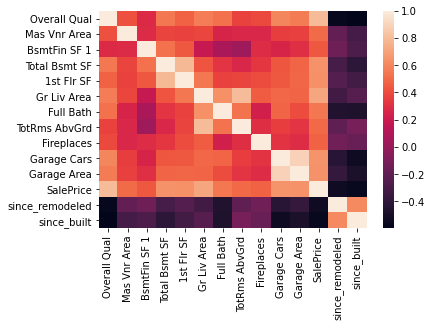

In [14]:
## Let's look at how features correlate with each other
sns.heatmap(df.corr())
plt.show()

As you can see over, 'Garage Cars' and 'Garage Area' are highly correlated which means that the two columns contain almost identical information but in different measurement. The same can be seen with 'TotRms AbvGrd' and 'Gr Liv Area'. I'm going to drop one feature from each set to avoid information redundancy.

In [15]:
## Drop the columns that contain more ambiguous measurement
df = df.drop(columns=['Garage Cars', 'TotRms AbvGrd'])

## Categorical values:

For any text column to be used in the model, it should be converted to a numeric values. One way to do so is to transform each non-numeric value into binary value within the columns. Any column that can be categorized as nominal variable is candidate for being converted to categorical. In order to convert those columns to categorical:
* I have to set a limit for how many unique values each those columns should have and drop any column that exceeds the limit. 
* From the remaining columns that don't exceed the limit I will drop the columns that have low variance. Low variance means that values are almost identical and therefore aren't spread out
* Convert the remaining columns to categorical datatype and create a dummy dataframe from them
* Combine the original dataset with dummy dataset

In [16]:
## Nominal columns
obj_cols = df.select_dtypes('object').columns
obj_cols

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Heating', 'Heating QC', 'Central Air', 'Kitchen Qual',
       'Functional', 'Paved Drive'],
      dtype='object')

In [17]:
## Let's find out how mand unique values are in each text column
uniqueness = dict()
for i in obj_cols:
    uniqueness[i] = len(df[i].unique())
unique_series = pd.Series(uniqueness).sort_values(ascending=False)
unique_series

Neighborhood    28
Exterior 2nd    17
Exterior 1st    16
Condition 1      9
Condition 2      8
House Style      8
Functional       8
Roof Matl        8
MS Zoning        7
Roof Style       6
Foundation       6
Heating          6
Exter Cond       5
Bldg Type        5
Heating QC       5
Kitchen Qual     5
Lot Config       5
Exter Qual       4
Land Contour     4
Lot Shape        4
Land Slope       3
Utilities        3
Paved Drive      3
Central Air      2
Street           2
dtype: int64

In [18]:
## The limit is 10 unique values per column, any column that has more than that is going to be dropped
df = df.drop(columns=unique_series[unique_series > 10].index)

In [19]:
## Find the columns where more than 95% of values belong to a specific category
variance = df[df.select_dtypes(include='object').columns].describe().loc['freq'].sort_values(ascending=False)/len(df)*100
not_diverse_cols = variance[variance > 95].index
variance

Utilities       99.8975
Street            99.59
Condition 2     99.0092
Roof Matl       98.5309
Heating         98.4626
Land Slope      95.1828
Central Air     93.3037
Functional      93.0987
Paved Drive     90.5022
Land Contour    89.9214
Exter Cond      86.9833
Condition 1      86.095
Bldg Type       82.7468
Roof Style       79.262
MS Zoning       77.5538
Lot Config      73.0441
Lot Shape       63.5121
Exter Qual      61.4622
Kitchen Qual     51.042
Heating QC      50.9737
House Style     50.5637
Foundation      44.6532
Name: freq, dtype: object

In [20]:
## Drop the columns that have low variance (not diverse)
df = df.drop(columns=not_diverse_cols)

In [21]:
## Now let's convert the remaining columns to categorical datatype
for i in df.select_dtypes(include='object').columns:
    df[i] = df[i].astype('category')

In [22]:
## Create a dummy dataframe from all the categorical columns
dummy = pd.get_dummies(df.select_dtypes(include='category'))

In [23]:
df.shape

(2927, 28)

In [24]:
dummy.shape

(2927, 86)

In [25]:
## Let's concatenate the original dataset with the dummy dataset
df = pd.concat([df, dummy], axis=1)

In [26]:
## Drop the columns that I used to produce the dummy dataset
df = df.drop(columns=df.select_dtypes(include='category').columns)

In [27]:
## Overview of the final dataset
df

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,Fireplaces,Garage Area,SalePrice,since_remodeled,since_built,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_N,Central Air_Y,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,6,112.0,639.0,1080.0,1656,1656,1,2,528.0,215000,50,50,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,5,0.0,468.0,882.0,896,896,1,0,730.0,105000,49,49,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,6,108.0,923.0,1329.0,1329,1329,1,0,312.0,172000,52,52,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,7,0.0,1065.0,2110.0,2110,2110,2,2,522.0,244000,42,42,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,5,0.0,791.0,928.0,928,1629,2,1,482.0,189900,12,13,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,6,0.0,819.0,1003.0,1003,1003,1,0,588.0,142500,22,22,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2926,5,0.0,301.0,864.0,902,902,1,0,484.0,131000,23,23,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2927,5,0.0,337.0,912.0,970,970,1,0,0.0,132000,14,14,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2928,5,0.0,1071.0,1389.0,1389,1389,1,1,418.0,170000,31,32,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


## Designing the model:

Now that we are done with feature engineering, it is time to build the model. 
* Use all the columns as features for the model
* Use Hold-out and Cross-validation methods to experiment with different number of folds 
* Plot rmse values from different folds (splits)

In [28]:
## Create a function that takes number of folds as parameter and returns RMSE for the corresponding k parameter 
def train_test(k):
    features = df.columns.drop('SalePrice')
    target = 'SalePrice'
    
    ## Hold-out method (Train/Test)
    if k == 0:
        ln = LinearRegression()
        train = df[:1463]
        test = df[1463:]
        ln.fit(train[features], train[target])
        prediction = ln.predict(test[features])
        mse = mean_squared_error(test[target], prediction)
        rmse = np.sqrt(mse)
        return rmse
    
    ## 2 Folds (Train/Test, Test/Train)
    elif k == 1:
        ln = LinearRegression()
        train = df[:1463]
        test = df[1463:]
        ln.fit(train[features], train[target])
        prediction_1 = ln.predict(test[features])
        mse_1 = mean_squared_error(test[target], prediction_1)
        rmse_1 = np.sqrt(mse_1)
        
        ln.fit(test[features], test[target])
        prediction_2 = ln.predict(train[features])
        mse_2 = mean_squared_error(train[target], prediction_2)
        rmse_2 = np.sqrt(mse_2)
        
        avg_rmse = (rmse_1 + rmse_2)/2
        return avg_rmse
    
    ## Cross-validation method (2 or more folds)
    else:  
        kf = KFold(n_splits=k, random_state=1, shuffle=True)
        ln = LinearRegression()
        mses = cross_val_score(ln, df[features], df[target], scoring='neg_mean_squared_error', cv=kf)    
        rmses = [np.sqrt(abs(i)) for i in mses]
        avg_rmse = np.mean(rmses)
        return avg_rmse

In [29]:
## Let's experiment with 20 folds and see the outcome in pandas series
frequency = dict()
for i in range(21):
    frequency[i] = train_test(i)

performance = pd.Series(frequency)
performance

0     33058.214153
1     30375.814363
2     29946.421729
3     29114.441237
4     29052.567488
5     28825.549341
6     28662.057485
7     28853.442004
8     28742.073221
9     28562.607486
10    28511.274411
11    28382.750222
12    28357.805858
13    28255.844860
14    28382.306821
15    28195.599022
16    28383.075527
17    28324.793909
18    27898.564559
19    27835.330184
20    27706.647478
dtype: float64

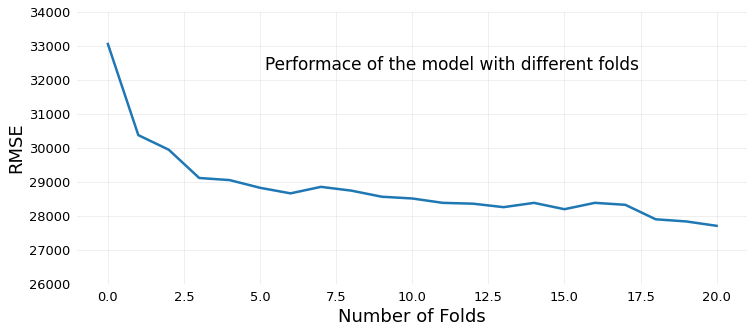

In [30]:
## Let's plot the above table to have a better picture about the model's performace
fig, ax = plt.subplots(figsize=(12,5))
x = list(performance.index)
y = list(performance.values)
ax.plot(x, y, linewidth=2.5)
for i in ['left', 'right', 'top', 'bottom']:
    ax.spines[i].set_visible(False)

ax.tick_params(axis='both', labelsize=13)
ax.set_ylim(26000, 34000)
ax.set_xlabel('Number of Folds', size=18)
ax.set_ylabel('RMSE', size=18)
ax.grid(alpha=0.25)
ax.tick_params(bottom=0, left=0)
ax.text(5.15, 32300, 'Performace of the model with different folds', size=17)
plt.show()

### RMSE:

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are. RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. Besides RMSE, let's see how much accurate the prediction model is. Since 20 folds performed relatively better than other combinations, let's see accuracy score of 20 folds.

In [31]:
## Accuracy at 20 folds
kf = KFold(n_splits=20, random_state=1, shuffle=True)
ln = LinearRegression()
scores = cross_val_score(ln, df[df.columns.drop('SalePrice')], df['SalePrice'], cv=kf)    
accuracy_score = round(np.mean(scores), 4)*100
print("The model is {}% accurate with cross-validation of 20 folds".format(accuracy_score))

The model is 87.4% accurate with cross-validation of 20 folds


## Conclusion:

Before fitting the features into the model, I went through data cleaning and feature engineering process. Strongly relying on correlation between potential features and target (Sale Price), limited domain knowledge in housing and my intuition, I was able to come up with the set of features for the model. As you can see above, the model performs around 33000 RMSE (root mean square error) with Hold-out method (train/test split). However, as the number of folds increase, the RMSE decreases which is a good indicative. In other words, the more we use each part of the dataset for training and testing, the less biased our prediction model is. At 20 folds, RMSE dropped to around 27800 RMSE which is approximately 87.4% accuracy. This model showed relatively best performace with 87.4% accuracy under 20 folds.

## THE END